# Data Preparation:

Data obtained from the MNIST database website (LeCun, Cortes, Burges) [here](http://yann.lecun.com/exdb/mnist/), downloaded locally through browser. 

The files are in IDX form, see the bottom of the linked page for more information.  We use the idx2numpy package to handle the data. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import Counter
import math
import tensorflow as tf

# Note: If you are using Anaconda and you used PIP install in the prompt to get the pacakge, 
# you need to make sure it's installed to the correct environment. For example, use 
# "activate py36" in the prompt before installing the package.

try:
    import idx2numpy
except:
    print("Package not found.")

In [6]:
# Read the IDX file in as a numpy array. I have the data saved in a folder labeled MNIST.

train_images = idx2numpy.convert_from_file('MNIST//train-images.idx3-ubyte')
train_labels = idx2numpy.convert_from_file('MNIST//train-labels.idx1-ubyte')
test_images = idx2numpy.convert_from_file('MNIST//t10k-images.idx3-ubyte')
test_labels = idx2numpy.convert_from_file('MNIST//t10k-labels.idx1-ubyte')

A function to check that the data makes sense. 

The image data is stored as what could be described as an a array of matrices, so that for example, train_images\[0\] is a $28\times 28$ matrix of grey-scale integer pixel values (0=white, 255 = black). The pyplot imshow function will display such a matrix as an image. 

In [7]:
def show_random_image(image_array, label_array):
    num_images = len(image_array)
    random_int = random.randint(0,num_images-1)
    plt.imshow(image_array[random_int], cmap = 'Greys')
    print("Index: " + str(random_int))
    print("Label: " + str(label_array[random_int]))
    return

Index: 49057
Label: 3


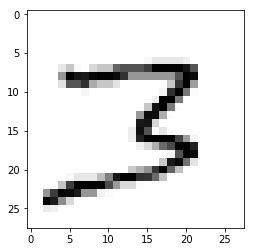

In [8]:
show_random_image(train_images, train_labels)

Index: 4160
Label: 6


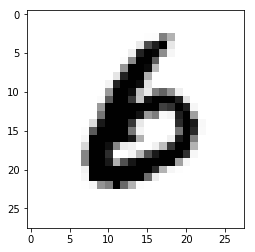

In [10]:
show_random_image(test_images, test_labels)

## Check for data balance:  

In [11]:
train_class_count = Counter()
for label in train_labels:
    train_class_count[label] += 1
    
print("Instance of classes: ", end = '')
print(train_class_count)

Instance of classes: Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


In [12]:
test_class_count = Counter()
for label in test_labels:
    test_class_count[label] += 1
    
print("Instance of classes: ", end = '')
print(test_class_count)

Instance of classes: Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


## Construct a balanced training/validation set:



In [13]:
def train_validation_split(data_array, label_array, train_ratio):
    labels = np.unique(label_array) # An array of the distinct entry values occuring in the argument.
    train_indices = []
    valid_indices = []
    for label in labels:
        label_indices = [i for i,x in enumerate(label_array) if x == label]
        instance_count = len(label_indices)
        partition = int(math.floor(train_ratio*instance_count))
        random.shuffle(label_indices)
        to_train = label_indices[:partition]
        to_valid = label_indices[partition:]
        train_indices = train_indices + to_train
        valid_indices = valid_indices + to_valid
    random.shuffle(train_indices)
    random.shuffle(valid_indices)
    train_data = data_array[train_indices]
    train_labels = label_array[train_indices]
    valid_data = data_array[valid_indices]
    valid_labels = label_array[valid_indices]
    return train_data, train_labels, valid_data, valid_labels

In [14]:
train_images, train_labels, valid_images, valid_labels = train_validation_split(train_images, train_labels, .8)

print("Test Size: " + str(len(train_images)))
print("Validation Size: " + str(len(valid_images)))

train_class_count = Counter()
for label in train_labels:
    train_class_count[label] += 1
    
print("Instance of classes: ", end = '')
print(train_class_count)

valid_class_count = Counter()
for label in valid_labels:
    valid_class_count[label] += 1
    
print("Instance of classes: ", end = '')
print(valid_class_count)

Test Size: 47995
Validation Size: 12005
Instance of classes: Counter({1: 5393, 7: 5012, 3: 4904, 2: 4766, 9: 4759, 0: 4738, 6: 4734, 8: 4680, 4: 4673, 5: 4336})
Instance of classes: Counter({1: 1349, 7: 1253, 3: 1227, 2: 1192, 9: 1190, 0: 1185, 6: 1184, 8: 1171, 4: 1169, 5: 1085})


Index: 32890
Label: 9


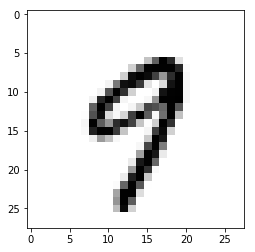

In [15]:
show_random_image(train_images, train_labels)

Index: 10856
Label: 9


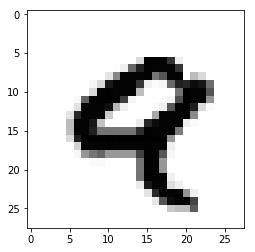

In [16]:
show_random_image(valid_images, valid_labels)

Reformat the data as a 2 dimensional array for matrix operations.

In [17]:
# Flatten images, normalize them between -1 and 1, and one-hot encode the labels. 

def reformat(images, labels):
    out_images = images.reshape((-1,28*28)).astype(np.float32)
    out_images = (out_images-(255.)/2)/255.
    out_labels = (np.arange(10) == labels[:,None]).astype(np.float32)
    return out_images, out_labels

# Unflatten images. Need: unencode labels [gracefully - probably np.where(array = 1) somehow].

def unreformat(images):
    out_images = images.reshape((-1,28,28)).astype(np.float32)
    return out_images

In [18]:
train_images, train_labels = reformat(train_images, train_labels)
valid_images, valid_labels = reformat(valid_images, valid_labels)
test_images, test_labels = reformat(test_images, test_labels)

In [19]:
print("Training Data Shape: " + str(train_images.shape))
print("Validation Data Shape: " + str(valid_images.shape))
print("Test Data Shape: " + str(test_images.shape))

print("Training Labels Shape: " + str(train_labels.shape))
print("Validation Labels Shape: " + str(valid_labels.shape))
print("Test Labels Shape: " + str(test_labels.shape))

Training Data Shape: (47995, 784)
Validation Data Shape: (12005, 784)
Test Data Shape: (10000, 784)
Training Labels Shape: (47995, 10)
Validation Labels Shape: (12005, 10)
Test Labels Shape: (10000, 10)


# Neural Network Constructions:

In [34]:
def accuracy(predicted_labels, true_labels):
    return(100*np.sum(np.argmax(predicted_labels, 1)==np.argmax(true_labels, 1))
           /predicted_labels.shape[0])

## Simple regression classifier

In [16]:
regression_graph = tf.Graph()

with regression_graph.as_default():
    # Feed in the constant data.
    T = tf.constant(train_images)
    Tlabel = tf.constant(train_labels)
    V = tf.constant(valid_images)
    E = tf.constant(test_images)
    # Establish variable matrix and bias vector.
    W = tf.Variable(tf.truncated_normal([784, 10])) # Randomly initialized.
    b = tf.Variable(tf.zeros([10])) # Initialized at origin. 
    # Do the logit computation.
    L = tf.matmul(T,W)+b
    # Do the softmax and crossentropy.
    l = tf.nn.softmax_cross_entropy_with_logits(labels = Tlabel, logits = L)
    # Take the average to get the loss function output.
    loss = tf.reduce_mean(l)
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    # Monitoring outputs.
    train_predictions = tf.nn.softmax(L)
    valid_predictions = tf.nn.softmax(tf.matmul(V,W)+b)
    test_predictions = tf.nn.softmax(tf.matmul(E,W)+b)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [17]:
number_of_iterations = 1000

with tf.Session(graph = regression_graph) as session:
    tf.global_variables_initializer().run()
    print('Variables Initialized')
    for iteration in range(number_of_iterations):
        session.run(optimizer)
        if (iteration % 100 == 0):
            print('Iteration %d: ' % iteration, end="")
            l = loss.eval()
            print('loss = %f, ' % l, end="")
            train_predict = train_predictions.eval()
            print(' training accuracy = %.1f%%' % accuracy(train_predict, train_labels), end=", ")
            valid_predict = valid_predictions.eval()
            print(' validation accuracy = %.1f%%.' % accuracy(valid_predict, valid_labels))
    test_predict = test_predictions.eval()
    print('Test accuracy: %.1f%%' % accuracy(test_predict, test_labels))

Variables Initialized
Iteration 0: loss = 14.652564,  training accuracy = 9.7%,  validation accuracy = 9.7%.
Iteration 100: loss = 1.189335,  training accuracy = 75.3%,  validation accuracy = 75.2%.
Iteration 200: loss = 0.861220,  training accuracy = 81.2%,  validation accuracy = 81.3%.
Iteration 300: loss = 0.726796,  training accuracy = 83.7%,  validation accuracy = 83.5%.
Iteration 400: loss = 0.649219,  training accuracy = 85.1%,  validation accuracy = 84.8%.
Iteration 500: loss = 0.597067,  training accuracy = 86.0%,  validation accuracy = 85.6%.
Iteration 600: loss = 0.558825,  training accuracy = 86.6%,  validation accuracy = 86.2%.
Iteration 700: loss = 0.529230,  training accuracy = 87.2%,  validation accuracy = 86.7%.
Iteration 800: loss = 0.505484,  training accuracy = 87.6%,  validation accuracy = 87.2%.
Iteration 900: loss = 0.485915,  training accuracy = 88.0%,  validation accuracy = 87.5%.
Test accuracy: 88.4%


## Stochastic Regression

Train the weights against small batches instead of the whole dataset at once. 

In [18]:
stochastic_regression_graph = tf.Graph()
batch_size = 1000

with stochastic_regression_graph.as_default():
    # Placeholders to feed batches of training data.
    T = tf.placeholder(tf.float32, shape=(batch_size, 784)) # Trains batches of 100.
    Tlabel = tf.placeholder(tf.float32, shape=(batch_size, 10))
    # Validation and test data remain constant.
    V = tf.constant(valid_images)
    E = tf.constant(test_images)
    # Establish variable matrix and bias vector.
    W = tf.Variable(tf.truncated_normal([784, 10])) # Randomly initialized.
    b = tf.Variable(tf.zeros([10])) # Initialized at origin. 
    # logit computation
    L = tf.matmul(T,W)+b
    # softmax, crossentropy and loss
    smce = tf.nn.softmax_cross_entropy_with_logits(labels = Tlabel, logits = L)
    loss = tf.reduce_mean(smce)
    # Optimize
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    # Monitoring outputs.
    train_predictions = tf.nn.softmax(L)
    valid_predictions = tf.nn.softmax(tf.matmul(V,W)+b)
    test_predictions = tf.nn.softmax(tf.matmul(E,W)+b)

In [19]:
number_of_epochs = 1000

with tf.Session(graph = stochastic_regression_graph) as session:
    tf.global_variables_initializer().run()
    epoch = 0
    print('Variables Initialized.')
    last_offset = 0
    iteration = 0
    inner_epoch_samples = 0
    last_epoch = -1
    while epoch <= number_of_epochs+1:
        # Generate Batches
        offset = (iteration * batch_size) % (train_labels.shape[0]-batch_size)
        batch_data = train_images[offset :(offset + batch_size), : ]
        batch_labels = train_labels[offset : (offset + batch_size), : ]
        
        # Randomize Within Batch: This slows things down but may be better pratice.
        randomized_indices = list(range(batch_size))
        random.shuffle(randomized_indices)
        randomized_batch_data = batch_data[randomized_indices]
        randomized_batch_labels = batch_labels[randomized_indices]
        
        # Run Model
        feed_dict = {T : randomized_batch_data, Tlabel : randomized_batch_labels}
        _, l, train_predict = session.run([optimizer, loss, train_predictions], feed_dict = feed_dict)
        iteration += 1
        inner_epoch_samples += batch_size
        
        # Report
        if (epoch % 100) == 0 and epoch > last_epoch:
            print('Epoch %d, Iteration: %d' % (epoch, iteration))
            print('loss = %f' % l, end = ", ")
            train_acc = accuracy(train_predict, randomized_batch_labels)
            print('training accuracy = %.1f%%' % train_acc, end = ", ")
            valid_acc = accuracy(valid_predictions.eval(), valid_labels)
            print('validation accuracy = %.1f%%.' % valid_acc)
            last_epoch = epoch
        if inner_epoch_samples - train_labels.shape[0] > 0:
            inner_epoch_samples = inner_epoch_samples - (train_labels.shape[0]+1)
            epoch += 1
    test_predict = test_predictions.eval()
    print('Test accuracy: %.1f%%' % accuracy(test_predict, test_labels))

Variables Initialized.
Epoch 0, Iteration: 1
loss = 13.845592, training accuracy = 9.3%, validation accuracy = 15.3%.
Epoch 100, Iteration: 4801
loss = 0.283729, training accuracy = 92.1%, validation accuracy = 90.6%.
Epoch 200, Iteration: 9601
loss = 0.268764, training accuracy = 92.6%, validation accuracy = 90.9%.
Epoch 300, Iteration: 14400
loss = 0.301649, training accuracy = 92.5%, validation accuracy = 91.2%.
Epoch 400, Iteration: 19200
loss = 0.191351, training accuracy = 94.4%, validation accuracy = 91.5%.
Epoch 500, Iteration: 23999
loss = 0.255783, training accuracy = 93.3%, validation accuracy = 91.4%.
Epoch 600, Iteration: 28799
loss = 0.261805, training accuracy = 93.2%, validation accuracy = 91.7%.
Epoch 700, Iteration: 33599
loss = 0.234398, training accuracy = 93.6%, validation accuracy = 91.7%.
Epoch 800, Iteration: 38398
loss = 0.172036, training accuracy = 95.1%, validation accuracy = 91.5%.
Epoch 900, Iteration: 43198
loss = 0.229250, training accuracy = 93.8%, vali

## Fully Connected Neural Network, 1 Hidden Layer

In [20]:
batch_size = 100
number_of_nodes = 1024 # Note: Results in a bigger network, so decrease learning rate. 

FCNN_1HL_graph = tf.Graph()

def FCNN_1HL_model(data, dropout = True):
        log1 = tf.matmul(data, W1) + b1
        hid1 = tf.nn.leaky_relu(log1)
        if dropout:
            hid1 = tf.nn.dropout(hid1, keep_prob = .5)
        log2 = tf.matmul(hid1, W2)+b2
        return log2

with FCNN_1HL_graph.as_default():
    T = tf.placeholder(tf.float32, shape=(batch_size, 784)) # Trains batches of 100.
    Tlabel = tf.placeholder(tf.float32, shape=(batch_size, 10))
    # Validation and test data remain constant.
    V = tf.constant(valid_images)
    E = tf.constant(test_images)
    # Establish variable matrices and bias vectors.
    W1 = tf.Variable(tf.random_normal([784, number_of_nodes]))
    b1 = tf.Variable(tf.zeros([number_of_nodes]))
    W2 = tf.Variable(tf.truncated_normal([number_of_nodes, 10]))
    b2 = tf.Variable(tf.zeros([10])) 
    # Model
    L = FCNN_1HL_model(T)
    # logits, softmax, crossentropy and loss
    smce = tf.nn.softmax_cross_entropy_with_logits(labels = Tlabel, logits = L)
    loss = tf.reduce_mean(smce)
    # Optimize
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    # Monitoring outputs.
    train_predictions = tf.nn.softmax(FCNN_1HL_model(T, dropout = False))
    valid_predictions = tf.nn.softmax(FCNN_1HL_model(V, dropout = False))
    test_predictions = tf.nn.softmax(FCNN_1HL_model(E, dropout = False))

In [21]:
number_of_epochs = 20

with tf.Session(graph = FCNN_1HL_graph) as session:
    tf.global_variables_initializer().run()
    epoch = 0
    print('Variables Initialized.')
    last_offset = 0
    iteration = 0
    inner_epoch_samples = 0
    last_epoch = -1
    while epoch <= number_of_epochs+1:
        # Generate Batches
        offset = (iteration * batch_size) % (train_labels.shape[0]-batch_size)
        batch_data = train_images[offset :(offset + batch_size), : ]
        batch_labels = train_labels[offset : (offset + batch_size), : ]
        
        # Randomize Within Batch: This slows things down but may be better pratice in general.
        randomized_indices = list(range(batch_size))
        random.shuffle(randomized_indices)
        randomized_batch_data = batch_data[randomized_indices]
        randomized_batch_labels = batch_labels[randomized_indices]
    
        # Run Model
        feed_dict = {T : randomized_batch_data, Tlabel : randomized_batch_labels}
        _, l, train_predict = session.run([optimizer, loss, train_predictions], feed_dict = feed_dict)
        iteration += 1
        inner_epoch_samples += batch_size
        
        # Report
        if (epoch % 2) == 0 and epoch > last_epoch:
            print('Epoch %d, Iteration: %d' % (epoch, iteration))
            print('loss = %f' % l, end = ", ")
            train_acc = accuracy(train_predict, randomized_batch_labels)
            print('training accuracy = %.1f%%' % train_acc, end = ", ")
            valid_acc = accuracy(valid_predictions.eval(), valid_labels)
            print('validation accuracy = %.1f%%.' % valid_acc)
            last_epoch = epoch
        if inner_epoch_samples - train_labels.shape[0] > 0:
            inner_epoch_samples = inner_epoch_samples - (train_labels.shape[0]+1)
            epoch += 1
    test_predict = test_predictions.eval()
    print('Test accuracy: %.1f%%' % accuracy(test_predict, test_labels))

Variables Initialized.
Epoch 0, Iteration: 1
loss = 649.817566, training accuracy = 10.0%, validation accuracy = 12.2%.
Epoch 2, Iteration: 961
loss = 15.403095, training accuracy = 91.0%, validation accuracy = 91.8%.
Epoch 4, Iteration: 1921
loss = 15.983130, training accuracy = 92.0%, validation accuracy = 93.3%.
Epoch 6, Iteration: 2881
loss = 5.002710, training accuracy = 99.0%, validation accuracy = 94.0%.
Epoch 8, Iteration: 3841
loss = 3.689040, training accuracy = 94.0%, validation accuracy = 94.4%.
Epoch 10, Iteration: 4801
loss = 3.825443, training accuracy = 96.0%, validation accuracy = 94.8%.
Epoch 12, Iteration: 5761
loss = 3.221264, training accuracy = 94.0%, validation accuracy = 94.9%.
Epoch 14, Iteration: 6721
loss = 4.457300, training accuracy = 95.0%, validation accuracy = 95.1%.
Epoch 16, Iteration: 7681
loss = 0.806422, training accuracy = 96.0%, validation accuracy = 95.4%.
Epoch 18, Iteration: 8641
loss = 1.326221, training accuracy = 96.0%, validation accuracy =

## Fully Connected Neural Network, 4 Hidden Layers

In [22]:
batch_size = 100
entry_number_of_nodes = 1024 # Note: Results in a MUCH bigger network with divisions, 
                        #so decrease learning rate/initialization standard deviation. 

learning_rate = .025
init_stddev = .05

FCNN_4HL_graph = tf.Graph()



with FCNN_4HL_graph.as_default():
    # Placeholder for batch data.
    T = tf.placeholder(tf.float32, shape=(batch_size, 784))
    Tlabel = tf.placeholder(tf.float32, shape=(batch_size, 10))
    # Validation and test data remain constant.
    V = tf.constant(valid_images)
    E = tf.constant(test_images)
    # Establish variable matrices and bias vectors.
    W1 = tf.Variable(tf.random_normal([784, number_of_nodes], stddev = init_stddev))
    b1 = tf.Variable(tf.zeros([number_of_nodes]))
    W2 = tf.Variable(tf.truncated_normal([number_of_nodes, int(number_of_nodes/2)], stddev = init_stddev))
    b2 = tf.Variable(tf.zeros([int(number_of_nodes/2)])) 
    W3 = tf.Variable(tf.truncated_normal([int(number_of_nodes/2), int(number_of_nodes/4)], stddev = init_stddev))
    b3 = tf.Variable(tf.zeros([int(number_of_nodes/4)])) 
    W4 = tf.Variable(tf.truncated_normal([int(number_of_nodes/4), int(number_of_nodes/8)], stddev = init_stddev))
    b4 = tf.Variable(tf.zeros([int(number_of_nodes/8)])) 
    W5 = tf.Variable(tf.truncated_normal([int(number_of_nodes/8), 10], stddev = init_stddev))
    b5 = tf.Variable(tf.zeros([10])) 
    # Model
    def FCNN_4HL_model(data, dropout = True):
        log1 = tf.matmul(data, W1) + b1
        hid1 = tf.nn.leaky_relu(log1)
        if dropout:
            hid1 = tf.nn.dropout(hid1, keep_prob = .5)
        log2 = tf.matmul(hid1, W2)+b2
        hid2 = tf.nn.leaky_relu(log2)
        if dropout:
            hid2 = tf.nn.dropout(hid2, keep_prob = .5)
        log3 = tf.matmul(hid2, W3)+b3
        hid3 = tf.nn.leaky_relu(log3)
        if dropout:
            hid3 = tf.nn.dropout(hid3, keep_prob = .5)
        log4 = tf.matmul(hid3, W4)+b4
        hid4 = tf.nn.leaky_relu(log4)
        if dropout:
            hid4 = tf.nn.dropout(hid4, keep_prob = .5)
        log5 = tf.matmul(hid4, W5)+b5
        return log5
    
    
    # logits, softmax, crossentropy and loss
    L = FCNN_4HL_model(T)
    smce = tf.nn.softmax_cross_entropy_with_logits(labels = Tlabel, logits = L)
    loss = tf.reduce_mean(smce)
    # Optimize
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    # Monitoring outputs.
    train_predictions = tf.nn.softmax(FCNN_4HL_model(T, dropout = False))
    valid_predictions = tf.nn.softmax(FCNN_4HL_model(V, dropout = False))
    test_predictions = tf.nn.softmax(FCNN_4HL_model(E, dropout = False))

In [23]:
number_of_epochs = 20

with tf.Session(graph = FCNN_4HL_graph) as session:
    tf.global_variables_initializer().run()
    epoch = 0
    print('Variables Initialized.')
    last_offset = 0
    iteration = 0
    inner_epoch_samples = 0
    last_epoch = -1
    while epoch <= number_of_epochs+1:
        # Generate Batches
        offset = (iteration * batch_size) % (train_labels.shape[0]-batch_size)
        batch_data = train_images[offset :(offset + batch_size), : ]
        batch_labels = train_labels[offset : (offset + batch_size), : ]
        
        # Randomize Within Batch: This slows things down but may be better pratice in general.
        randomized_indices = list(range(batch_size))
        random.shuffle(randomized_indices)
        randomized_batch_data = batch_data[randomized_indices]
        randomized_batch_labels = batch_labels[randomized_indices]
    
        # Run Model
        feed_dict = {T : randomized_batch_data, Tlabel : randomized_batch_labels}
        _, l, train_predict = session.run([optimizer, loss, train_predictions], feed_dict = feed_dict)
        iteration += 1
        inner_epoch_samples += batch_size
        
        # Report
        if (epoch % 2) == 0 and epoch > last_epoch:
            print('Epoch %d, Iteration: %d' % (epoch, iteration))
            print('loss = %f' % l, end = ", ")
            train_acc = accuracy(train_predict, randomized_batch_labels)
            print('training accuracy = %.1f%%' % train_acc, end = ", ")
            valid_acc = accuracy(valid_predictions.eval(), valid_labels)
            print('validation accuracy = %.1f%%.' % valid_acc)
            last_epoch = epoch
        if inner_epoch_samples - train_labels.shape[0] > 0:
            inner_epoch_samples = inner_epoch_samples - (train_labels.shape[0]+1)
            epoch += 1
    test_predict = test_predictions.eval()
    print('Test accuracy: %.1f%%' % accuracy(test_predict, test_labels))

Variables Initialized.
Epoch 0, Iteration: 1
loss = 2.386708, training accuracy = 13.0%, validation accuracy = 12.3%.
Epoch 2, Iteration: 961
loss = 0.765348, training accuracy = 84.0%, validation accuracy = 87.0%.
Epoch 4, Iteration: 1921
loss = 0.432627, training accuracy = 92.0%, validation accuracy = 90.4%.
Epoch 6, Iteration: 2881
loss = 0.291401, training accuracy = 90.0%, validation accuracy = 92.1%.
Epoch 8, Iteration: 3841
loss = 0.306259, training accuracy = 95.0%, validation accuracy = 93.3%.
Epoch 10, Iteration: 4801
loss = 0.269199, training accuracy = 95.0%, validation accuracy = 94.0%.
Epoch 12, Iteration: 5761
loss = 0.225274, training accuracy = 93.0%, validation accuracy = 94.3%.
Epoch 14, Iteration: 6721
loss = 0.298702, training accuracy = 94.0%, validation accuracy = 94.8%.
Epoch 16, Iteration: 7681
loss = 0.218531, training accuracy = 96.0%, validation accuracy = 95.2%.
Epoch 18, Iteration: 8641
loss = 0.164751, training accuracy = 98.0%, validation accuracy = 95.

## Convolutional Neural Network

In [24]:
def reformat_for_CNN(images):
    out_images = images.reshape((-1, 28, 28, 1)).astype(np.float32)
    return out_images

train_images_CNN = reformat_for_CNN(train_images)
valid_images_CNN = reformat_for_CNN(valid_images)
test_images_CNN = reformat_for_CNN(test_images)

print("Train shape: "+ str(train_images_CNN.shape))
print("Valid shape: "+ str(valid_images_CNN.shape))
print("Test shape: "+ str(test_images_CNN.shape))

Train shape: (47995, 28, 28, 1)
Valid shape: (12005, 28, 28, 1)
Test shape: (10000, 28, 28, 1)


In [26]:
batch_size = 16
patch_size = 5
depth = 16
number_of_nodes = 64
number_of_nodes2 =32

number_of_channels = 1
number_of_labels = 10
image_size = 28

init_learning_rate = 0.05
init_stddev = .1

CNN_graph = tf.Graph()

with CNN_graph.as_default():

    # Input data.
    T = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, number_of_channels))
    Tlabel = tf.placeholder(tf.float32, shape=(batch_size, number_of_labels))
    V = tf.constant(valid_images_CNN)
    E = tf.constant(test_images_CNN)
  
    # Variables.
    W1 = tf.Variable(tf.truncated_normal([patch_size, patch_size, number_of_channels, depth], stddev=init_stddev))
    b1 = tf.Variable(tf.zeros([depth]))
    W2 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=init_stddev))
    b2 = tf.Variable(tf.constant(1.0, shape=[depth]))
    W3 = tf.Variable(tf.truncated_normal([64, number_of_nodes], stddev=init_stddev))
    b3 = tf.Variable(tf.constant(1.0, shape=[number_of_nodes]))
    W4 = tf.Variable(tf.truncated_normal([number_of_nodes, number_of_nodes2], stddev=init_stddev))
    b4 = tf.Variable(tf.constant(1.0, shape=[number_of_nodes2]))
    W5 = tf.Variable(tf.truncated_normal([number_of_nodes2, number_of_labels], stddev=init_stddev))
    b5 = tf.Variable(tf.constant(1.0, shape=[number_of_labels]))
    
    # Model.
    def model(data, dropout = True):
        conv1 = tf.nn.conv2d(data, W1, [1, 2, 2, 1], padding='SAME')
        hid1 = tf.nn.leaky_relu(conv1 + b1)
        pool1 = tf.nn.max_pool(value = hid1, ksize = [1, 2, 2, 1], strides = [1,2,2,1], padding = 'SAME')
        conv2 = tf.nn.conv2d(pool1, W2, [1, 2, 2, 1], padding='SAME')
        hid2 = tf.nn.leaky_relu(conv2 + b2)
        pool2 = tf.nn.max_pool(value = hid2, ksize = [1, 2, 2, 1], strides = [1,2,2,1], padding = 'SAME')
        shape = pool2.get_shape().as_list()
        reshape = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])
        log3 = tf.matmul(reshape, W3) + b3
        hid3 = tf.nn.leaky_relu(log3)
        if dropout == True:
            hid3 = tf.nn.dropout(hid3, keep_prob = .5)
        log4 = tf.matmul(hid3, W4) + b4
        hid4 = tf.nn.leaky_relu(log4)
        if dropout == True:
            hid4 = tf.nn.dropout(hid4, keep_prob = .5)
        log5 = tf.matmul(hid4, W5) + b5
        return log5
  
    # logits, softmax, crossentropy and loss
    L = model(T)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Tlabel, logits=L))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(init_learning_rate).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_predictions = tf.nn.softmax(model(T, dropout = False))
    valid_predictions = tf.nn.softmax(model(V, dropout = False))
    test_predictions = tf.nn.softmax(model(E, dropout = False))

In [27]:
number_of_iterations = 20000

with tf.Session(graph=CNN_graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for iteration in range(number_of_iterations):
        # Generate batch.
        offset = (iteration * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_images_CNN[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
    
        # Run model.
        feed_dict = {T : batch_data, Tlabel : batch_labels}
        _, l, train_predict = session.run([optimizer, loss, train_predictions], feed_dict=feed_dict)
        if (iteration % 1000) == 0:
            print('Iteration: %d' % iteration)
            print('loss = %f' % l, end = ", ")
            train_acc = accuracy(train_predict, batch_labels)
            print('training accuracy = %.1f%%' % train_acc, end = ", ")
            valid_acc = accuracy(valid_predictions.eval(), valid_labels)
            print('validation accuracy = %.1f%%.' % valid_acc)
    print('Test accuracy: %.1f%%' % accuracy(test_predictions.eval(), test_labels))
  

Initialized
Iteration: 0
loss = 3.292928, training accuracy = 0.0%, validation accuracy = 9.7%.
Iteration: 1000
loss = 0.578934, training accuracy = 68.8%, validation accuracy = 84.4%.
Iteration: 2000
loss = 0.617082, training accuracy = 93.8%, validation accuracy = 93.9%.
Iteration: 3000
loss = 0.021760, training accuracy = 100.0%, validation accuracy = 95.0%.
Iteration: 4000
loss = 0.027779, training accuracy = 100.0%, validation accuracy = 96.0%.
Iteration: 5000
loss = 0.047241, training accuracy = 100.0%, validation accuracy = 96.2%.
Iteration: 6000
loss = 0.259676, training accuracy = 93.8%, validation accuracy = 96.4%.
Iteration: 7000
loss = 0.069597, training accuracy = 100.0%, validation accuracy = 96.2%.
Iteration: 8000
loss = 0.184429, training accuracy = 100.0%, validation accuracy = 96.9%.
Iteration: 9000
loss = 0.294641, training accuracy = 87.5%, validation accuracy = 96.7%.
Iteration: 10000
loss = 0.118383, training accuracy = 93.8%, validation accuracy = 96.3%.
Iteratio

# Do Androids Count Electric Sheep With MNIST Digits?

In [20]:
def scramble_images(train, valid, test):
    column_index = list(range(28*28))
    random.shuffle(column_index)
    return train[:, column_index], valid[:, column_index], test[:, column_index]

scrambled_train_images, scrambled_valid_images, scrambled_test_images = scramble_images(train_images, 
                                                                                        valid_images, 
                                                                                        test_images)

Index: 40872
Label: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


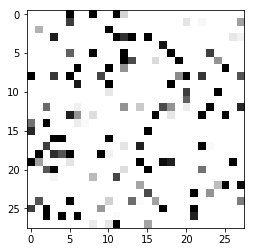

In [39]:
deformatted_scrambled_train_images = scrambled_train_images.reshape(-1,28,28)
show_random_image(deformatted_scrambled_train_images, train_labels)

## Stochastic Regression on Scrambled Images

In [31]:
stochastic_regression_graph = tf.Graph()
batch_size = 1000

with stochastic_regression_graph.as_default():
    # Placeholders.
    T = tf.placeholder(tf.float32, shape=(batch_size, 784)) # Trains batches of 100.
    Tlabel = tf.placeholder(tf.float32, shape=(batch_size, 10))
    # Constants.
    V = tf.constant(scrambled_valid_images)
    E = tf.constant(scrambled_test_images)
    # Variables.
    W = tf.Variable(tf.truncated_normal([784, 10])) # Randomly initialized.
    b = tf.Variable(tf.zeros([10])) # Initialized at origin. 
    # Model.
    L = tf.matmul(T,W)+b
    # softmax, crossentropy and loss
    smce = tf.nn.softmax_cross_entropy_with_logits_v2(labels = Tlabel, logits = L)
    loss = tf.reduce_mean(smce)
    # Optimize
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    # Monitoring outputs.
    scrambled_train_predictions = tf.nn.softmax(L)
    scrambled_valid_predictions = tf.nn.softmax(tf.matmul(V,W)+b)
    scrambled_test_predictions = tf.nn.softmax(tf.matmul(E,W)+b)

In [35]:
number_of_epochs = 1000

with tf.Session(graph = stochastic_regression_graph) as session:
    tf.global_variables_initializer().run()
    epoch = 0
    print('Variables Initialized.')
    last_offset = 0
    iteration = 0
    inner_epoch_samples = 0
    last_epoch = -1
    while epoch <= number_of_epochs+1:
        # Generate Batches
        offset = (iteration * batch_size) % (train_labels.shape[0]-batch_size)
        batch_data = scrambled_train_images[offset :(offset + batch_size), : ]
        batch_labels = train_labels[offset : (offset + batch_size), : ]
        
        # Randomize Within Batch: This slows things down but may be better pratice.
        randomized_indices = list(range(batch_size))
        random.shuffle(randomized_indices)
        randomized_batch_data = batch_data[randomized_indices]
        randomized_batch_labels = batch_labels[randomized_indices]
        
        # Run Model
        feed_dict = {T : randomized_batch_data, Tlabel : randomized_batch_labels}
        _, l, train_predict = session.run([optimizer, loss, scrambled_train_predictions], feed_dict = feed_dict)
        iteration += 1
        inner_epoch_samples += batch_size
        
        # Report
        if (epoch % 100) == 0 and epoch > last_epoch:
            print('Epoch %d, Iteration: %d' % (epoch, iteration))
            print('loss = %f' % l, end = ", ")
            train_acc = accuracy(train_predict, randomized_batch_labels)
            print('training accuracy = %.1f%%' % train_acc, end = ", ")
            valid_acc = accuracy(scrambled_valid_predictions.eval(), valid_labels)
            print('validation accuracy = %.1f%%.' % valid_acc)
            last_epoch = epoch
        if inner_epoch_samples - train_labels.shape[0] > 0:
            inner_epoch_samples = inner_epoch_samples - (train_labels.shape[0]+1)
            epoch += 1
    scrambled_test_predict = scrambled_test_predictions.eval()
    print('Test accuracy: %.1f%%' % accuracy(scrambled_test_predict, test_labels))

Variables Initialized.
Epoch 0, Iteration: 1
loss = 22.711788, training accuracy = 7.8%, validation accuracy = 8.9%.
Epoch 100, Iteration: 4801
loss = 0.302894, training accuracy = 91.3%, validation accuracy = 90.4%.
Epoch 200, Iteration: 9601
loss = 0.292581, training accuracy = 91.5%, validation accuracy = 90.8%.
Epoch 300, Iteration: 14400
loss = 0.210696, training accuracy = 93.1%, validation accuracy = 91.2%.
Epoch 400, Iteration: 19200
loss = 0.268976, training accuracy = 92.9%, validation accuracy = 91.4%.
Epoch 500, Iteration: 23999
loss = 0.231109, training accuracy = 94.1%, validation accuracy = 91.2%.
Epoch 600, Iteration: 28799
loss = 0.203045, training accuracy = 94.3%, validation accuracy = 91.5%.
Epoch 700, Iteration: 33599
loss = 0.232386, training accuracy = 94.4%, validation accuracy = 91.7%.
Epoch 800, Iteration: 38398
loss = 0.237743, training accuracy = 93.4%, validation accuracy = 91.8%.
Epoch 900, Iteration: 43198
loss = 0.204907, training accuracy = 94.2%, valid

## Fully Connected Neural Network, 4 Hidden Layers on Scrambled Images

In [41]:
batch_size = 100
number_of_nodes = 1024 
learning_rate = .025
init_stddev = .05

FCNN_4HL_graph = tf.Graph()

with FCNN_4HL_graph.as_default():
    # Placeholder.
    T = tf.placeholder(tf.float32, shape=(batch_size, 784))
    Tlabel = tf.placeholder(tf.float32, shape=(batch_size, 10))
    # Constant.
    V = tf.constant(scrambled_valid_images)
    E = tf.constant(scrambled_test_images)
    # Variables.
    W1 = tf.Variable(tf.random_normal([784, number_of_nodes], stddev = init_stddev))
    b1 = tf.Variable(tf.zeros([number_of_nodes]))
    W2 = tf.Variable(tf.truncated_normal([number_of_nodes, int(number_of_nodes/2)], stddev = init_stddev))
    b2 = tf.Variable(tf.zeros([int(number_of_nodes/2)])) 
    W3 = tf.Variable(tf.truncated_normal([int(number_of_nodes/2), int(number_of_nodes/4)], stddev = init_stddev))
    b3 = tf.Variable(tf.zeros([int(number_of_nodes/4)])) 
    W4 = tf.Variable(tf.truncated_normal([int(number_of_nodes/4), int(number_of_nodes/8)], stddev = init_stddev))
    b4 = tf.Variable(tf.zeros([int(number_of_nodes/8)])) 
    W5 = tf.Variable(tf.truncated_normal([int(number_of_nodes/8), 10], stddev = init_stddev))
    b5 = tf.Variable(tf.zeros([10])) 
    # Model
    def FCNN_4HL_model(data, dropout = True):
        log1 = tf.matmul(data, W1) + b1
        hid1 = tf.nn.leaky_relu(log1)
        if dropout:
            hid1 = tf.nn.dropout(hid1, keep_prob = .5)
        log2 = tf.matmul(hid1, W2)+b2
        hid2 = tf.nn.leaky_relu(log2)
        if dropout:
            hid2 = tf.nn.dropout(hid2, keep_prob = .5)
        log3 = tf.matmul(hid2, W3)+b3
        hid3 = tf.nn.leaky_relu(log3)
        if dropout:
            hid3 = tf.nn.dropout(hid3, keep_prob = .5)
        log4 = tf.matmul(hid3, W4)+b4
        hid4 = tf.nn.leaky_relu(log4)
        if dropout:
            hid4 = tf.nn.dropout(hid4, keep_prob = .5)
        log5 = tf.matmul(hid4, W5)+b5
        return log5
    
    
    # logits, softmax, crossentropy and loss
    L = FCNN_4HL_model(T)
    smce = tf.nn.softmax_cross_entropy_with_logits_v2(labels = Tlabel, logits = L)
    loss = tf.reduce_mean(smce)
    # Optimize
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    # Monitoring outputs.
    scrambled_train_predictions = tf.nn.softmax(FCNN_4HL_model(T, dropout = False))
    scrambled_valid_predictions = tf.nn.softmax(FCNN_4HL_model(V, dropout = False))
    scrambled_test_predictions = tf.nn.softmax(FCNN_4HL_model(E, dropout = False))

In [43]:
number_of_epochs = 20

with tf.Session(graph = FCNN_4HL_graph) as session:
    tf.global_variables_initializer().run()
    epoch = 0
    print('Variables Initialized.')
    last_offset = 0
    iteration = 0
    inner_epoch_samples = 0
    last_epoch = -1
    while epoch <= number_of_epochs+1:
        # Generate Batches
        offset = (iteration * batch_size) % (train_labels.shape[0]-batch_size)
        batch_data = scrambled_train_images[offset :(offset + batch_size), : ]
        batch_labels = train_labels[offset : (offset + batch_size), : ]
        
        # Randomize Within Batch: This slows things down but may be better pratice in general.
        randomized_indices = list(range(batch_size))
        random.shuffle(randomized_indices)
        randomized_batch_data = batch_data[randomized_indices]
        randomized_batch_labels = batch_labels[randomized_indices]
    
        # Run Model
        feed_dict = {T : randomized_batch_data, Tlabel : randomized_batch_labels}
        _, l, train_predict = session.run([optimizer, loss, scrambled_train_predictions], feed_dict = feed_dict)
        iteration += 1
        inner_epoch_samples += batch_size
        
        # Report
        if (epoch % 2) == 0 and epoch > last_epoch:
            print('Epoch %d, Iteration: %d' % (epoch, iteration))
            print('loss = %f' % l, end = ", ")
            train_acc = accuracy(train_predict, randomized_batch_labels)
            print('training accuracy = %.1f%%' % train_acc, end = ", ")
            valid_acc = accuracy(scrambled_valid_predictions.eval(), valid_labels)
            print('validation accuracy = %.1f%%.' % valid_acc)
            last_epoch = epoch
        if inner_epoch_samples - train_labels.shape[0] > 0:
            inner_epoch_samples = inner_epoch_samples - (train_labels.shape[0]+1)
            epoch += 1
    test_predict = scrambled_test_predictions.eval()
    print('Test accuracy: %.1f%%' % accuracy(scrambled_test_predict, test_labels))

Variables Initialized.
Epoch 0, Iteration: 1
loss = 2.358292, training accuracy = 11.0%, validation accuracy = 12.8%.
Epoch 2, Iteration: 961
loss = 0.559024, training accuracy = 86.0%, validation accuracy = 86.8%.
Epoch 4, Iteration: 1921
loss = 0.456431, training accuracy = 89.0%, validation accuracy = 91.0%.
Epoch 6, Iteration: 2881
loss = 0.470253, training accuracy = 89.0%, validation accuracy = 92.4%.
Epoch 8, Iteration: 3841
loss = 0.333921, training accuracy = 88.0%, validation accuracy = 93.5%.
Epoch 10, Iteration: 4801
loss = 0.321924, training accuracy = 90.0%, validation accuracy = 94.4%.
Epoch 12, Iteration: 5761
loss = 0.254863, training accuracy = 96.0%, validation accuracy = 94.8%.
Epoch 14, Iteration: 6721
loss = 0.237653, training accuracy = 95.0%, validation accuracy = 95.2%.
Epoch 16, Iteration: 7681
loss = 0.175100, training accuracy = 96.0%, validation accuracy = 95.6%.
Epoch 18, Iteration: 8641
loss = 0.130864, training accuracy = 96.0%, validation accuracy = 95.

## Convolutional Neural Network

In [44]:
def reformat_for_CNN(images):
    out_images = images.reshape((-1, 28, 28, 1)).astype(np.float32)
    return out_images

scrambled_train_images_CNN = reformat_for_CNN(scrambled_train_images)
scrambled_valid_images_CNN = reformat_for_CNN(scrambled_valid_images)
scrambled_test_images_CNN = reformat_for_CNN(scrambled_test_images)

print("Train shape: "+ str(scrambled_train_images_CNN.shape))
print("Valid shape: "+ str(scrambled_valid_images_CNN.shape))
print("Test shape: "+ str(scrambled_test_images_CNN.shape))

Train shape: (47995, 28, 28, 1)
Valid shape: (12005, 28, 28, 1)
Test shape: (10000, 28, 28, 1)


In [45]:
batch_size = 16
patch_size = 5
depth = 16
number_of_nodes = 64
number_of_nodes2 =32

number_of_channels = 1
number_of_labels = 10
image_size = 28

init_learning_rate = 0.05
init_stddev = .1

CNN_graph = tf.Graph()

with CNN_graph.as_default():

    # Input data.
    T = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, number_of_channels))
    Tlabel = tf.placeholder(tf.float32, shape=(batch_size, number_of_labels))
    V = tf.constant(scrambled_valid_images_CNN)
    E = tf.constant(scrambled_test_images_CNN)
  
    # Variables.
    W1 = tf.Variable(tf.truncated_normal([patch_size, patch_size, number_of_channels, depth], stddev=init_stddev))
    b1 = tf.Variable(tf.zeros([depth]))
    W2 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=init_stddev))
    b2 = tf.Variable(tf.constant(1.0, shape=[depth]))
    W3 = tf.Variable(tf.truncated_normal([64, number_of_nodes], stddev=init_stddev))
    b3 = tf.Variable(tf.constant(1.0, shape=[number_of_nodes]))
    W4 = tf.Variable(tf.truncated_normal([number_of_nodes, number_of_nodes2], stddev=init_stddev))
    b4 = tf.Variable(tf.constant(1.0, shape=[number_of_nodes2]))
    W5 = tf.Variable(tf.truncated_normal([number_of_nodes2, number_of_labels], stddev=init_stddev))
    b5 = tf.Variable(tf.constant(1.0, shape=[number_of_labels]))
    
    # Model.
    def model(data, dropout = True):
        conv1 = tf.nn.conv2d(data, W1, [1, 2, 2, 1], padding='SAME')
        hid1 = tf.nn.leaky_relu(conv1 + b1)
        pool1 = tf.nn.max_pool(value = hid1, ksize = [1, 2, 2, 1], strides = [1,2,2,1], padding = 'SAME')
        conv2 = tf.nn.conv2d(pool1, W2, [1, 2, 2, 1], padding='SAME')
        hid2 = tf.nn.leaky_relu(conv2 + b2)
        pool2 = tf.nn.max_pool(value = hid2, ksize = [1, 2, 2, 1], strides = [1,2,2,1], padding = 'SAME')
        shape = pool2.get_shape().as_list()
        reshape = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])
        log3 = tf.matmul(reshape, W3) + b3
        hid3 = tf.nn.leaky_relu(log3)
        if dropout == True:
            hid3 = tf.nn.dropout(hid3, keep_prob = .5)
        log4 = tf.matmul(hid3, W4) + b4
        hid4 = tf.nn.leaky_relu(log4)
        if dropout == True:
            hid4 = tf.nn.dropout(hid4, keep_prob = .5)
        log5 = tf.matmul(hid4, W5) + b5
        return log5
  
    # logits, softmax, crossentropy and loss
    L = model(T)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Tlabel, logits=L))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(init_learning_rate).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    scrambled_train_predictions = tf.nn.softmax(model(T, dropout = False))
    scrambled_valid_predictions = tf.nn.softmax(model(V, dropout = False))
    scrambled_test_predictions = tf.nn.softmax(model(E, dropout = False))

In [46]:
number_of_iterations = 20000

with tf.Session(graph=CNN_graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for iteration in range(number_of_iterations):
        # Generate batch.
        offset = (iteration * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = scrambled_train_images_CNN[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
    
        # Run model.
        feed_dict = {T : batch_data, Tlabel : batch_labels}
        _, l, train_predict = session.run([optimizer, loss, scrambled_train_predictions], feed_dict=feed_dict)
        if (iteration % 1000) == 0:
            print('Iteration: %d' % iteration)
            print('loss = %f' % l, end = ", ")
            train_acc = accuracy(train_predict, batch_labels)
            print('training accuracy = %.1f%%' % train_acc, end = ", ")
            valid_acc = accuracy(scrambled_valid_predictions.eval(), valid_labels)
            print('validation accuracy = %.1f%%.' % valid_acc)
    print('Test accuracy: %.1f%%' % accuracy(scrambled_test_predictions.eval(), test_labels))
  

Initialized
Iteration: 0
loss = 2.433147, training accuracy = 25.0%, validation accuracy = 9.9%.
Iteration: 1000
loss = 1.266197, training accuracy = 56.2%, validation accuracy = 40.2%.
Iteration: 2000
loss = 0.727661, training accuracy = 56.2%, validation accuracy = 78.3%.
Iteration: 3000
loss = 0.408943, training accuracy = 100.0%, validation accuracy = 86.3%.
Iteration: 4000
loss = 1.211791, training accuracy = 75.0%, validation accuracy = 88.2%.
Iteration: 5000
loss = 1.054869, training accuracy = 81.2%, validation accuracy = 89.7%.
Iteration: 6000
loss = 0.664420, training accuracy = 81.2%, validation accuracy = 90.7%.
Iteration: 7000
loss = 0.352289, training accuracy = 93.8%, validation accuracy = 91.4%.
Iteration: 8000
loss = 0.443306, training accuracy = 93.8%, validation accuracy = 92.3%.
Iteration: 9000
loss = 0.169416, training accuracy = 100.0%, validation accuracy = 93.2%.
Iteration: 10000
loss = 0.406815, training accuracy = 93.8%, validation accuracy = 92.9%.
Iteration:

### Conclusion: They may count sheep thusly...

But having only a mild drop in performance on the scrambled images suggests that these architectures have yet to capture the essence of visual data.  Its still mysterious to me why this drop in performance occurred at all; there are two feasible explanations (optimization difficulty and batch training) that explain the degredataion in a way that doesn't defeat the suggestion that vision has yet to be captured theoretically.

It would be interesting to try this experiment on some of the deeper, higher-performing models referenced at the bottom of [this page](http://yann.lecun.com/exdb/mnist/).